In [2]:
import numpy as np

import matplotlib.pyplot as plt
from scipy.integrate import odeint
import mpmath as mpmath

# %matplotlib notebook 
%matplotlib inline 

#import Husimi   # quantum routines
import Harp     # Classical integration routines
import importlib  # for reloading routines

In [ ]:
#importlib.reload(Harp)  # if you need to reload it!

## drifting the perturbed classical Harper model

Should we integrate an orbit without drifting. 
Then use all the points as initial conditions for drifting?

In [108]:
# routines for classical drifting system integration 

twopi = 2.0*np.pi

# parameters $a,b,\epsilon,\mu, \mu_p$ all can drift

# dy/dt = func(y,t), needed for integrator!
# note that y[0] = phi and y[1] = p
def cfunc_dr(y,tau,parms0,d_parmsdt):
    parms = parms0 + d_parmsdt*tau  # parameters drifting here 
    a = parms[0]
    b = parms[1]
    eps = parms[2]
    #mu = parms[3]
    #mup = parms[4]
    return [a*np.sin(y[1] - b) , -eps*np.sin(y[0])]
                 #- mu*np.sin(y[0] - tau) - mup*np.sin(y[0] + tau)]


# return unperturbed energy value from position in phase space
# neglect tau, mu, mu' but keep b
def H0_classical(p,phi,parms0): 
    a = parms0[0]
    b = parms0[1]
    eps = parms0[2]
    return a*(1.0 - np.cos(p-b)) - eps*np.cos(phi)

# return separatrix energies for above hamilonian
# ignoring time dependence and ignoring mu mu'
def sep_energies(parms0):
    a = parms0[0]
    eps = parms0[2]
    sep1 = a - eps   # 
    sep2 = -sep1  # 
    sep1 += a  # gives 2a-eps, higher one typically
    sep2 += a  # gives eps  lower one
    return np.array([sep2,sep1])  # separatrix energies for H0 as in routine H0_classical()
    # order low, high, if a>0,eps>0
    
# modulo so an array of angles is in [-pi,pi]
def respi(z_arr):
    phi_arr = z_arr%twopi # so that it is in [0:2pi]
    ii = phi_arr >np.pi
    phi_arr[ii]-= twopi # now phi is in [-pi,pi]
    return phi_arr
    

# integrate at a period, the forced pendulum 
# arguments:
#   y0: is initial conditions, it's a single point in phase space
#   npoints: is number of points we want
#   parms = [a,b,epsilon, mu, mup]: are parameters of the Hamiltonian model at tau=0
#   d_parmsdt = time derivatives of all parameters 
#   points of output are at times 0 + 2 pi n, integer n up to npoints 
#   integrate to every 2 pi period, npoints returned including initial condition 
# returns: phi,p arrays of integrated points 
# this particular routine does all times at once by sending a set of times to the integrator
def givepoints_arr_dr(y0,npoints,parms0,d_parmsdt):
    # set up time array, every 2pi/nu so for period of perturbation
    step  = 2.0*np.pi
    stop = step*npoints
    time  = np.arange(0.0,stop,step)  # time array for outputs  goes from 0 to stop-step 
    #                              with increment step, does not reach stop. 
    #time += taushift  # shift time vector 
    # do the integration
    y = odeint(cfunc_dr, y0, time, args=(parms0,d_parmsdt),rtol=1e-8,atol=1e-8)
    phi_arr = np.squeeze(y[:,0])  # is an array of phi at different times
    p_arr = np.squeeze(y[:,1])    # is an array of momenta at different times
    
    phi_arr = respi(phi_arr)  # so that phi in [-pi:pi]
    p_arr   = respi(p_arr) # so that p is in [-pi,pi]
    
    return phi_arr,p_arr 

colorlist = ['black','blue','green','magenta','orange','gold','blueviolet','springgreen','dodgerblue'] # 'red',

In [17]:

# For each one of the phase space points in the list (could be an orbit or a random selection in phase space), 
# drift the system and record final position after nperiods
# phi_arr,p_arr: phase space initial conditions (arrays of points)
# nperiods: how many periods to drift
# parms0 parametesr at tau=0
# d_parmsdt drift rate 
# returns end points of each orbit 
# no plots
def nper(phi_arr,p_arr,nperiods,parms0,d_parmsdt):
    phi_arr_end = phi_arr*0
    p_arr_end   = p_arr*0
    for k in range(len(phi_arr)):
        y0 = np.array([phi_arr[k],p_arr[k]])
        phi_arr_d,p_arr_d  = givepoints_arr_dr(y0,nperiods,parms0,d_parmsdt)
        p_arr_end[k] = p_arr_d[-1]
        phi_arr_end[k] = phi_arr_d[-1]
    return phi_arr_end,p_arr_end

# for each of the phase space points in the list, integrate orbits 
# and store all intermediate points at each period 
# this will help us compute things like expectation value of energy h0
# return full arrays of all orbits as well as only the end points 
def store_all_points(phi_arr,p_arr,nperiods,parms0,d_parmsdt):
    nn = len(phi_arr)
    phi_store = np.zeros((nn,nperiods))
    p_store =  np.zeros((nn,nperiods))
    for k in range(nn):
        y0 = np.array([phi_arr[k],p_arr[k]])
        phi_arr_d,p_arr_d  = givepoints_arr_dr(y0,nperiods,parms0,d_parmsdt)
        phi_store[k,:] = phi_arr_d
        p_store[k,:] = p_arr_d
        
    phi_arr_end = np.squeeze(phi_store[-1,:])
    p_arr_end   = np.squeeze(p_store[-1,:])
    return phi_store, p_store,phi_arr_end, p_arr_end

# compute unperturbed energy values mean and standard deviations for orbits 
# assuming parms are not drifting, ignores mu, mu', tau 
def h0stats(phi_arr,p_arr,parms0):
    hvals = H0_classical(p_arr,phi_arr,parms0)
    mu = np.mean(hvals)
    sig = np.std(hvals)
    return mu, sig

# compute h0 stats for 2d arrays which record surface of section orbits post drift 
def h0stats_2darrs(phi_store,p_store,parms0):
    nn = phi_store.shape[0]  # numbers of orbits
    mu_arr = np.zeros(nn)
    sig_arr = np.zeros(nn)
    for k in range(nn):
        phi_arr = np.squeeze(phi_store[k,:])
        p_arr = np.squeeze(p_store[k,:])
        mu, sig = h0stats(phi_arr,p_arr,parms0)
        mu_arr[k] = mu
        sig_arr[k] = sig
    return mu_arr,sig_arr


# compute and plot orbits of a set of points in phase space 
# the idea is these are finally positions after drifting 
# we want to compute the orbits now freezing the parameters so see where they ended up
# inputs:
#   phi_arr_end, p_arr_end: phase space positions after drifting, initial conditions for a new orbit set 
#   parms_end: parameters at the end of the drift : we freeze the parameters at these values
#   npoints: how many new points to compute in a surface of section that is computed with the frozen parameters
#   delta_p: shift in moment for the display of the newly computed orbits 
#   phi_arr_beg, p_arr_beg an additional set of phase space positions to plot (initial conditions prior to drifting)
# outputs: a plot showing initial conditions in red, and resulting surface of section generated from points postdrift
def mkend_plot(phi_arr_end,p_arr_end,parms_end,npoints,delta_p,phi_arr_beg,p_arr_beg):
    fig,ax = plt.subplots(1,1,figsize=(3,3),dpi=200)
    plt.subplots_adjust(bottom=0.18,top=0.90,left=0.18,right=0.98)
    ax.set_xlabel(r'$\phi$')
    ax.set_ylabel('p',labelpad=0)
    ax.set_aspect('equal')
    fac=1.01
    xmax = np.pi;  ymax = np.pi;  ymin = -ymax
    ax.set_xlim([-xmax*fac,xmax*fac])
    ax.set_ylim([ ymin*fac,ymax*fac])
    
    for k in range(len(phi_arr_end)):  #each point in phase sapce 
        y0 = np.array([phi_arr_end[k],p_arr_end[k]])  #initial conditions 
        phi_arr,p_arr = givepoints_arr_dr(y0,npoints,parms_end,parms_end*0)  # compute orbits, frozen parms

        pshift = respi(p_arr - delta_p) # display with momentum shift
        i = np.random.randint(low=0,high =len(colorlist))  # random colors 
        ax.scatter(phi_arr,pshift,s=0.5,edgecolor='none',facecolor=colorlist[i],lw=1)  # plot them 

    ax.scatter(phi_arr_beg,p_arr_beg,s=1.5,edgecolor='none',facecolor='red',lw=1)  # plot also these points, not shifted 
    plt.show()


# plot a surface of section (frozen parameters) along with another set of points in phase space 
# phi_arr_beg, p_arr_beg: are a set of points in phase space to plot in red
# parms0: are a set of parameters, frozen
# npoints, norbits: compute npoints of norbits with randomly chosen initial conditions integrated 
#   with the frozen parameter set
# and plot this surface of section  
# delta_p lets you shift p if you want to 
def mksurf(phi_arr_beg,p_arr_beg,parms0,norbits,npoints,delta_p,ofile):
    fig,ax = plt.subplots(1,1,figsize=(3,3),dpi=200)
    plt.subplots_adjust(bottom=0.18,top=0.90,left=0.18,right=0.98)
    ax.text(2.6,-3.9,r'$\phi$',fontsize=14)
    ax.set_ylabel('p',labelpad=0)
    ax.set_aspect('equal')
    #delta_p = 0.0
    fac=1.01
    xmax = np.pi;  ymax = np.pi;  ymin = -ymax
    ax.set_xlim([-xmax*fac,xmax*fac])
    ax.set_ylim([ ymin*fac,ymax*fac])

    for k in range(norbits):
        phi0 = np.random.uniform(low=-np.pi,high=np.pi)
        p0 = np.random.uniform(low=-np.pi,high=np.pi)
        y0 = [phi0,p0]
        phi_arr,p_arr = givepoints_arr_dr(y0,npoints,parms0,parms0*0)  # compute orbits, frozen parms
        i = np.random.randint(low=0,high =len(colorlist))  # random colors 
        pshift = respi(p_arr - delta_p)
        ax.scatter(phi_arr,pshift,s=0.5,edgecolor='none',facecolor=colorlist[i],lw=0.5)  # plot them 
      
    ax.scatter(phi_arr_beg,p_arr_beg,s=1.5,edgecolor='none',facecolor='red',lw=0.5)  # plot also these points, not shifted 

    if (len(ofile)>2):
        ofile_l = froot + '_sf.png'
        plt.savefig(ofile_l,dpi=200)
    plt.show()

# is like routine mkend_plot but using stored arrays for the orbits 
def mkend_plot2(phi_arr_beg,p_arr_beg,phi_store,p_store,delta_p,ofile):
    fig,ax = plt.subplots(1,1,figsize=(3,3),dpi=200)
    plt.subplots_adjust(bottom=0.18,top=0.90,left=0.18,right=0.98)
    ax.text(2.6,-3.9,r'$\phi$',fontsize=14)
    ax.set_ylabel('p',labelpad=0)
    ax.set_aspect('equal')
    fac=1.01
    xmax = np.pi;  ymax = np.pi;  ymin = -ymax
    ax.set_xlim([-xmax*fac,xmax*fac])
    ax.set_ylim([ ymin*fac,ymax*fac])

    norbits = p_store.shape[0]
    for k in range(norbits):
        i = np.random.randint(low=0,high =len(colorlist))  # random colors 
        pshift = respi(np.squeeze(p_store[k,:]) - delta_p)
        phi = np.squeeze(phi_store[k,:])
        ax.scatter(phi,pshift,s=0.5,edgecolor='none',facecolor=colorlist[i],lw=0.5)  # plot them 
      
    ax.scatter(phi_arr_beg,p_arr_beg,s=1.5,edgecolor='none',facecolor='red',lw=0.5)  # plot also these points, not shifted 
    
    if (len(ofile)>2):
        ofile_l = froot + '_endsf.png'
        plt.savefig(ofile_l,dpi=200)
        
    plt.show()
    


In [107]:
# integrate at a specific duration  (not necessarily at a period), the  pendulum 
# arguments:
#   y0: is initial conditions, it's a single point in phase space
#   parms = [a,b,epsilon, ..]: are parameters of the Hamiltonian model at tau=0
#   d_parmsdt = time derivatives of all parameters 
#   duration = time to integrate 
# returns: phi,p value after integrating this speficic duration 
def givepoint_dur(y0,duration,parms0,d_parmsdt):
    # set up time array, every 2pi/nu so for period of perturbation
    time  = np.array([0,duration])
    # time array for outputs  goes from 0 to duration 
    #time += taushift  # shift time vector 
    # do the integration
    y = odeint(cfunc_dr, y0, time, args=(parms0,d_parmsdt),atol=1e-10,rtol=1e-10)
    phi_arr = np.squeeze(y[:,0])  # is an array of phi at different times
    p_arr = np.squeeze(y[:,1])    # is an array of momenta at different times
    
    phi_arr = respi(phi_arr)  # so that phi in [-pi:pi]
    p_arr   = respi(p_arr) # so that p is in [-pi,pi]
    phi_final = phi_arr[-1]
    p_final = p_arr[-1]
    
    return phi_final,p_final

# For each one of the phase space points in the list (could be an orbit or a random selection in phase space), 
# drift the system and record final position after nperiods
# phi_arr,p_arr: phase space initial conditions (arrays of points)
# duration: how long to drift n
# parms0 parameters at tau=0
# d_parmsdt drift rate 
# returns end points of each orbit 
# no plots
def nper_dur(phi_arr,p_arr,duration,parms0,d_parmsdt):
    phi_arr_end = phi_arr*0
    p_arr_end   = p_arr*0
    for k in range(len(phi_arr)):
        y0 = np.array([phi_arr[k],p_arr[k]])
        phi_final,p_final  = givepoint_dur(y0,duration,parms0,d_parmsdt)
        p_arr_end[k] = p_final
        phi_arr_end[k] = phi_final
    return phi_arr_end,p_arr_end

In [109]:
# class definition for a drifting classical system 
class drift_sys():
    def __init__(self,parms0,d_parmsdt,npoints_in,y0,npoints_sf,norbits,nperiods_dur,ptype,froot):
        self.parms0 = parms0  # [a,b,eps,mu,mup] parameters 
        self.d_parmsdt = d_parmsdt  # rate of drift parameters  for [a,b,eps,mu,mup]
        self.y0 = y0  # initial condition for a particular orbit in form [phi0,p0]
        self.npoints_in = npoints_in  # number of points in initial conditions either an orbit w.o drift or randomly selected
        # or number of randomly selected initially points 
        self.npoints_sf = npoints_sf  # numbers of points in each orbit of initial surface of section (to figure)
        self.norbits = norbits  #  number of orbits in initial surface of section 
        
        self.froot = froot   # a string which we can later use to construct figures 
        self.ptype = ptype  # either nperiods or 'duration'
        if (ptype == 'nperiods'):
            self.nperiods = nperiods_dur  # drift periods, how long to drift 
            self.parms_end = self.parms0 + self.nperiods*2*np.pi*self.d_parmsdt  # compute final params after drift 
        else:
            self.duration = nperiods_dur  # drift duration, how long to drift 
            self.parms_end = self.parms0 + self.duration*self.d_parmsdt  # compute final params after drift 

        # compute separatrix energies at the beginning and end of drift 
        self.seps_beg = sep_energies(self.parms0)  # pairs of energies length 2 arrays
        self.seps_end = sep_energies(self.parms_end)
            
        self.Delta_b = self.parms_end[1] - self.parms0[1] # compute difference in b values if b is drifting
             
        if (self.Delta_b != 0):
            print('Delta_b = {:.3f}'.format(self.Delta_b))
            
        if (len(self.y0) < 2):
            print("Error: y0 should be a point in phase space (2d array)")

    # set up initial conditions 
    def mkbegs(self):
        # integrate the initial orbit with initial conditions y0 in phase space (not drifting)
        # the number of points in the orbit is npoints_in
        if (self.ptype =='nperiods'):
            self.phi_arr_beg,self.p_arr_beg = givepoints_arr_dr(self.y0,self.npoints_in,self.parms0,self.parms0*0.0)
        else:
            # choose initial conditions that are randomly distributed in phase space 
            # the number of points of initial conditions is npoints_in
            self.phi_arr_beg = np.random.uniform(low=-np.pi,high=np.pi,size=self.npoints_in)
            self.p_arr_beg   = np.random.uniform(low=-np.pi,high=np.pi,size=self.npoints_in)

    # show the initial orbit on a surface of section 
    # This routine integrates norbits with randomly chosen initial conditions and each one has npoints_sf
    # then the result is plotted 
    def surf(self,ofile):
        try:
            self.phi_arr_beg
        except AttributeError:
            print('error2: you need to run mkbegs first')
        else:
            mksurf(self.phi_arr_beg,self.p_arr_beg,self.parms0,self.norbits,self.npoints_sf,0.0,ofile)

    # make a surface of section for the post drift parameters (not drifting)
    # points are chosen randomly in phase space, initial conditions are ignored
    def surf_end(self,ofile):
        mksurf([],[],self.parms_end,self.norbits,self.npoints_sf,self.Delta_b,ofile)
        
    # drift the initial orbit, store the resulting end points, 
    def dodrift(self,ofile):
        # do the drift nperiods worth 
        try:
            self.phi_arr_beg
        except AttributeError: 
            print('error1: you need to run mkbegs first')
        else:
            if (self.ptype == 'nperiods'):
                self.phi_arr_end,self.p_arr_end = nper(self.phi_arr_beg,self.p_arr_beg,self.nperiods,self.parms0,self.d_parmsdt)
        
                # compute surface of section from final positions of orbits 
                self.phi_store_end, self.p_store_end,phi_junk, p_junk = \
                    store_all_points(self.phi_arr_end,self.p_arr_end,self.npoints_sf,self.parms_end,self.d_parmsdt*0)
                # show results!
                mkend_plot2(self.phi_arr_beg,self.p_arr_beg,self.phi_store_end,self.p_store_end,self.Delta_b,ofile) 
                # plot post drift orbits along with initial conditions
            # if self.ptype ='duration' then  integrate 
            else:
                self.phi_arr_end,self.p_arr_end = nper_dur(self.phi_arr_beg,self.p_arr_beg,self.duration,self.parms0,self.d_parmsdt)
                # do the drift for duration self.duration with random initial conditions 
 
    # compute the energy states for a set of points in phase space using the unperturbed hamiltonian 
    def h0stats(self):
        # compute energies stats for final surface of section 
        try:
            self.phi_store_end
        except AttributeError: 
            print('error: phi_store_end does not exist yet, dodrift first')
        else:
            self.mu_arr, self.sig_arr = h0stats_2darrs(self.phi_store_end,self.p_store_end,self.parms_end)
        try:
            self.phi_store_endr
        except AttributeError:
            x=1
        else: 
            self.mu_arr_r, self.sig_arr_r = h0stats_2darrs(self.phi_store_endr,self.p_store_endr,self.parms0)

    # let's reverse the drift!
    def reverse(self,ofile):
        # reverse the drift by flipping dparms/dt and starting with parms_end
        # and using the end points
        try: 
            self.phi_arr_end
        except AttributeError: 
            print('error: you need to run dodrift first')
        else: 
            self.phi_arr_endr,self.p_arr_endr = nper(self.phi_arr_end,self.p_arr_end,self.nperiods,self.parms_end,-1*self.d_parmsdt)

            # compute surface of section from final positions of orbits 
            self.phi_store_endr, self.p_store_endr,phi_junk, p_junk = \
                store_all_points(self.phi_arr_endr,self.p_arr_endr,self.npoints_sf,self.parms0,self.d_parmsdt*0)
            # show results!
            mkend_plot2(self.phi_arr_beg,self.p_arr_beg,self.phi_store_endr,self.p_store_endr,0.0,ofile) 
        

### We are going to drift numbers of periods which are in units of $2 \pi$
If we had $\Delta b = 10 \pi/N$ and duration of drift $T/\hbar = 100$.  This gave 
$T = 100 \hbar = 100 \frac{ 2 \pi}{N}$  This means that 
$ \frac{T}{2\pi} = \frac{T}{\hbar} \frac{\hbar}{2 \pi} = \frac{100}{N}$. 

$$ Nperiods = \frac{T}{2\pi} = \frac{T}{\hbar} \frac{\hbar}{2 \pi}  = \frac{T}{\hbar} \frac{1}{N} $$

$$ Duration = T = \frac{T}{\hbar} \hbar =  \frac{T}{\hbar} \frac{2 \pi}{N} $$

In [110]:

def cmp_trans_prob(sim):
    # compute energies at beginning and end of orbits 
    E_beg = H0_classical(sim.p_arr_beg,sim.phi_arr_beg,sim.parms0)
    E_end = H0_classical(sim.p_arr_end,sim.phi_arr_end,sim.parms_end)
    sep_low_beg = sim.seps_beg[0] # separatrix energies at beginning
    sep_hig_beg = sim.seps_beg[1]
    sep_low_end = sim.seps_end[0]  # separatrix energies at end 
    sep_hig_end = sim.seps_end[1]
    ptrans = np.zeros((3,3))
    for i in range(sim.npoints_in):
        if (E_beg[i] < sep_low_beg):  # in lib1 initially
            j =0 
            if (E_end[i] < sep_low_end): # in lib1 finally
                ptrans[j,0] += 1.
            if (sep_low_end <= E_end[i]) and (E_end[i] <= sep_hig_end) : #in circ finally
                ptrans[j,1] += 1.
            if (E_end[i] > sep_hig_end):  # in lib2 finally 
                ptrans[j,2] += 1.
        if (sep_low_beg <= E_beg[i]) and (E_beg[i] <= sep_hig_beg) : #in circ initially
            j =1 
            if (E_end[i] < sep_low_end): # in lib1 finally
                ptrans[j,0] += 1.
            if (sep_low_end <= E_end[i]) and (E_end[i] <= sep_hig_end) : #in circ finally
                ptrans[j,1] += 1.
            if (E_end[i] > sep_hig_end):  # in lib2 finally 
                ptrans[j,2] += 1.
        if (E_beg[i] > sep_hig_beg):  # in lib2 initially
            j =2 
            if (E_end[i] < sep_low_end): # in lib1 finally
                ptrans[j,0] += 1.
            if (sep_low_end <= E_end[i]) and (E_end[i] <= sep_hig_end) : #in circ finally
                ptrans[j,1] += 1.
            if (E_end[i] > sep_hig_end):  # in lib2 finally 
                ptrans[j,2] += 1.
    
    return ptrans/sim.npoints_in

#Ptrans = cmp_trans_prob(dsim1)
#print(Ptrans)

def Pseries(Tarr,Delta_b,Delta_eps,N,parms0,d_parmsdt,npoints_in):
    y0 = np.array([0.,1.]) 
    npoints_sf=150 # to make a surface of section plot at the beginning, predrift  
    norbits = 100  # number of orbits in initial surface of section plot 
    ptype = 'duration'
    eps_mid = parms0[2] + Delta_eps/2
    a0 = parms0[0]
    om2 = eps_mid*a0
    
    nser = len(Tarr)
    pstuff_big = np.zeros((nser,3,3))
    beta_list = np.zeros(nser)
    
    for k in range(nser):
        duration = Tarr[k]*2*np.pi/N
        db_dt = Delta_b/duration  # drift rate in b 
        print('Delta b',Delta_b,'db_dt',db_dt)
        deps_dt = Delta_eps/duration 
        d_parmsdt = np.array([0.0,db_dt,deps_dt,0,0])  # only b drifting 
        beta_ad = db_dt/om2
        print('beta_ad = {:.2e}'.format(beta_ad))
        beta_list[k] = beta_ad

        dsim = drift_sys(parms0,d_parmsdt,npoints_in,y0,npoints_sf,norbits,duration,ptype,'')
        dsim.mkbegs() # generate initial conditions 
        dsim.dodrift('') # integrate the orbits g
        Ptrans = cmp_trans_prob(dsim)  # compute the transition matrix
        print(Ptrans)
        pstuff_big[k,:,:] = Ptrans
    return pstuff_big,beta_list 

In [111]:
def Tarr_fig_probs(p_series,beta_list,Tarr,ablabel,ofile):
    nser = len(Tarr)
    fig,axarr = plt.subplots(1,nser,figsize=(6.0,1.6),sharex=True,sharey=True,dpi=300)
    plt.subplots_adjust(hspace=0,wspace=0,top=0.95,right=0.99,left=0.14,bottom=0.05)
    zmax = np.max(np.squeeze(p_series[:,:,:]))
    #eps_mid = (dclass.eps_0 + dclass.eps_final)/2
    #nn_b = dclass.d_b * dclass.nseries*dclass.n/np.pi + 1e-5
    cmap = 'Purples'
    for i in range(nser):
        T = Tarr[i]; 
        label2 = r'$T/\hbar$={:.0f}'.format(T)
        beta_ad = beta_list[i]
        if (beta_ad > 0.01):
            beta_lab = r'$\beta_{ad}$=' + '{:.2f}'.format(beta_ad)  # adiabatic limit
        else:
            beta_lab = r'$\beta_{ad}$=' + '{:.1e}'.format(beta_ad)
        #print(beta_lab)

        axarr[i].set_xticks([])
        axarr[i].set_yticks([])
        p_ma = np.squeeze(p_series[i,:,:])
        if (i==0):
            im0 = axarr[i].imshow(p_ma,origin='lower',cmap=cmap,vmin=0,vmax=zmax) # for colorbar
        else:
            im  = axarr[i].imshow(p_ma,origin='lower',cmap=cmap,vmin=0,vmax=zmax)
        axarr[i].text(0.02,0.92, label2, transform = axarr[i].transAxes,color='black',fontsize=8)
        axarr[i].text(0.02,0.84, beta_lab, transform = axarr[i].transAxes,color='green',fontsize=8)

    # colorbar
    cax0=fig.add_axes([0.08,0.16,0.012,0.64])
    cbar0 = plt.colorbar(im0,cax=cax0,location='left',label='probability',format="%4.1f",ticks=[0.0,0.1,0.2,0.3])  
    #axarr[0].text(0.0,1.03, l1, transform = axarr[0].transAxes)

    if (len(ofile)>3):
        plt.savefig(ofile)
    plt.show()
    


Delta b 1.0 db_dt 3.899296105751436
beta_ad = 7.80e+00
Delta_b = 1.000
[[0.181 0.122 0.   ]
 [0.154 0.091 0.132]
 [0.    0.144 0.176]]
Delta b 1.0 db_dt 0.3899296105751436
beta_ad = 7.80e-01
Delta_b = 1.000
[[0.182 0.129 0.   ]
 [0.143 0.116 0.135]
 [0.    0.134 0.161]]
Delta b 1.0 db_dt 0.038992961057514354
beta_ad = 7.80e-02
Delta_b = 1.000
[[0.253 0.056 0.   ]
 [0.06  0.274 0.048]
 [0.    0.068 0.241]]
Delta b 1.0 db_dt 0.003899296105751436
beta_ad = 7.80e-03
Delta_b = 1.000
[[0.205 0.109 0.   ]
 [0.124 0.132 0.124]
 [0.    0.124 0.182]]


/var/folders/l_/tk7gphlj0d38754sb6x8p1f00000gn/T/ipykernel_10237/4167057437.py:14: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  y = odeint(cfunc_dr, y0, time, args=(parms0,d_parmsdt),atol=1e-10,rtol=1e-10)


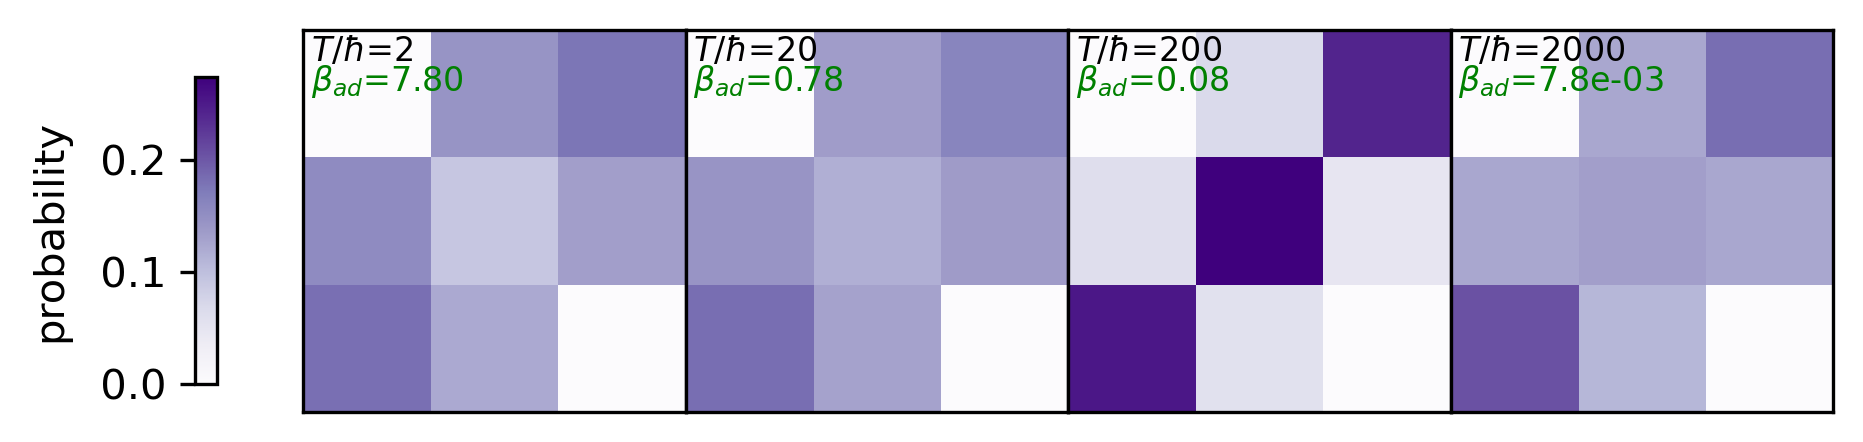

In [115]:
a = 1.; b=0.0; eps=0.5; mu=0.0; mup=mu;   # parameters at beginning 
parms0 = np.array([a,b,eps,mu,mup])
npoints_in = 1000;  # number of points for initial conditions orbit, predrift 

N=49
Delta_b = 1.  #   10*np.pi/N # total drift in b
Delta_eps = 0.0 # total drift in epsilon
Tarr_a = np.array([1,10,100,1000])*2  # these are T/hbar values 
pstuff_big_a,beta_a = Pseries(Tarr_a,Delta_b,Delta_eps,N,parms0,d_parmsdt,npoints_in)
Tarr_fig_probs(pstuff_big_a,beta_a,Tarr_a,'','')

In [117]:
a = 1.; b=0.0; eps=0.3; mu=0.0; mup=mu;   # parameters at beginning 
parms0 = np.array([a,b,eps,mu,mup])
npoints_in = 1000;  # number of points for initial conditions orbit, predrift 

N=49
Delta_b = 1. # total drift in b
Delta_eps = 0.1 # total drift in epsilon
Tarr_b = Tarr_a
pstuff_big_b,beta_b = Pseries(Tarr_b,Delta_b,Delta_eps,N,parms0,d_parmsdt,npoints_in)

#a = 1.; b=0.0; 
eps=0.1; #mu=0.0; mup=mu;   # parameters at beginning 
parms0 = np.array([a,b,eps,mu,mup])
#npoints_in = 350;  # number of points for initial conditions orbit, predrift 
#N=49
Delta_b = 1.  #20*np.pi/N # total drift in b
Delta_eps = 0.6 # total drift in epsilon
Tarr_c = Tarr_a
pstuff_big_c,beta_c = Pseries(Tarr_c,Delta_b,Delta_eps,N,parms0,d_parmsdt,npoints_in)


Delta b 1.0 db_dt 3.899296105751436
beta_ad = 1.11e+01
Delta_b = 1.000
[[0.108 0.109 0.   ]
 [0.182 0.214 0.167]
 [0.    0.112 0.108]]
Delta b 1.0 db_dt 0.3899296105751436
beta_ad = 1.11e+00
Delta_b = 1.000
[[0.1   0.128 0.   ]
 [0.134 0.231 0.179]
 [0.    0.12  0.108]]
Delta b 1.0 db_dt 0.038992961057514354
beta_ad = 1.11e-01
Delta_b = 1.000
[[0.196 0.045 0.   ]
 [0.087 0.362 0.089]
 [0.    0.045 0.176]]
Delta b 1.0 db_dt 0.003899296105751436
beta_ad = 1.11e-02
Delta_b = 1.000


/var/folders/l_/tk7gphlj0d38754sb6x8p1f00000gn/T/ipykernel_10237/4167057437.py:14: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  y = odeint(cfunc_dr, y0, time, args=(parms0,d_parmsdt),atol=1e-10,rtol=1e-10)


[[0.141 0.093 0.   ]
 [0.132 0.245 0.144]
 [0.    0.087 0.158]]
Delta b 1.0 db_dt 3.899296105751436
beta_ad = 9.75e+00
Delta_b = 1.000
[[0.109 0.027 0.   ]
 [0.263 0.205 0.257]
 [0.    0.025 0.114]]
Delta b 1.0 db_dt 0.3899296105751436
beta_ad = 9.75e-01
Delta_b = 1.000
[[0.093 0.015 0.   ]
 [0.266 0.21  0.277]
 [0.    0.019 0.12 ]]
Delta b 1.0 db_dt 0.038992961057514354
beta_ad = 9.75e-02
Delta_b = 1.000
[[0.102 0.006 0.   ]
 [0.269 0.212 0.286]
 [0.    0.001 0.124]]
Delta b 1.0 db_dt 0.003899296105751436
beta_ad = 9.75e-03
Delta_b = 1.000
[[0.156 0.    0.   ]
 [0.249 0.231 0.232]
 [0.    0.    0.132]]


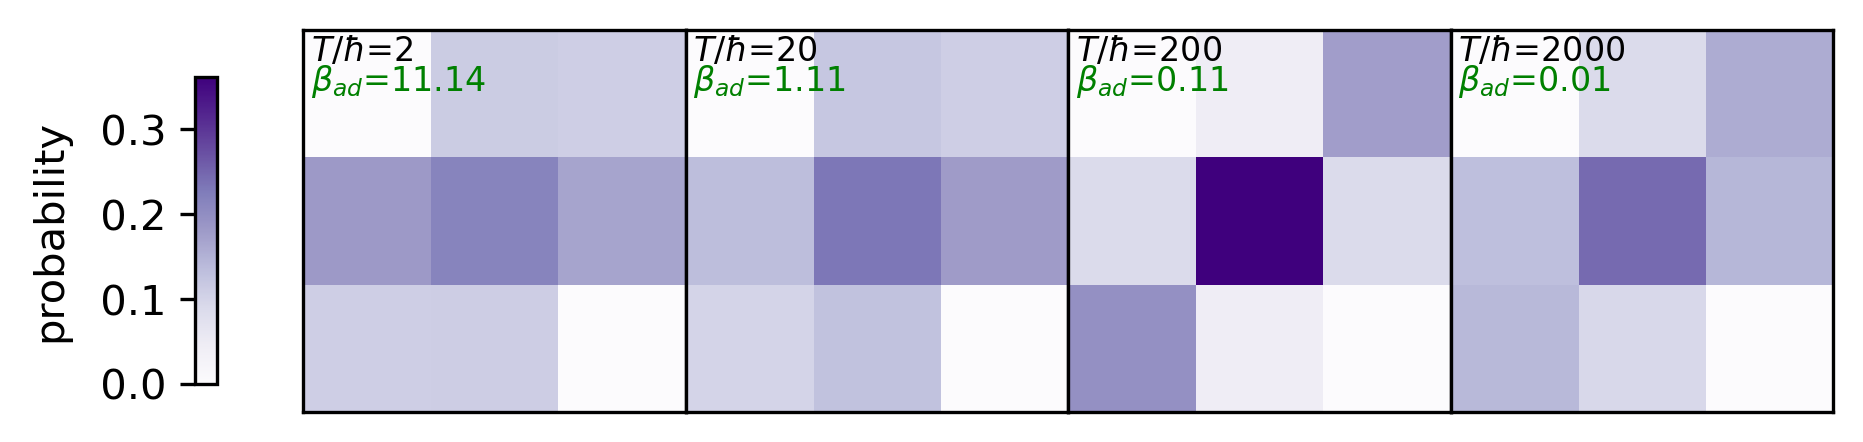

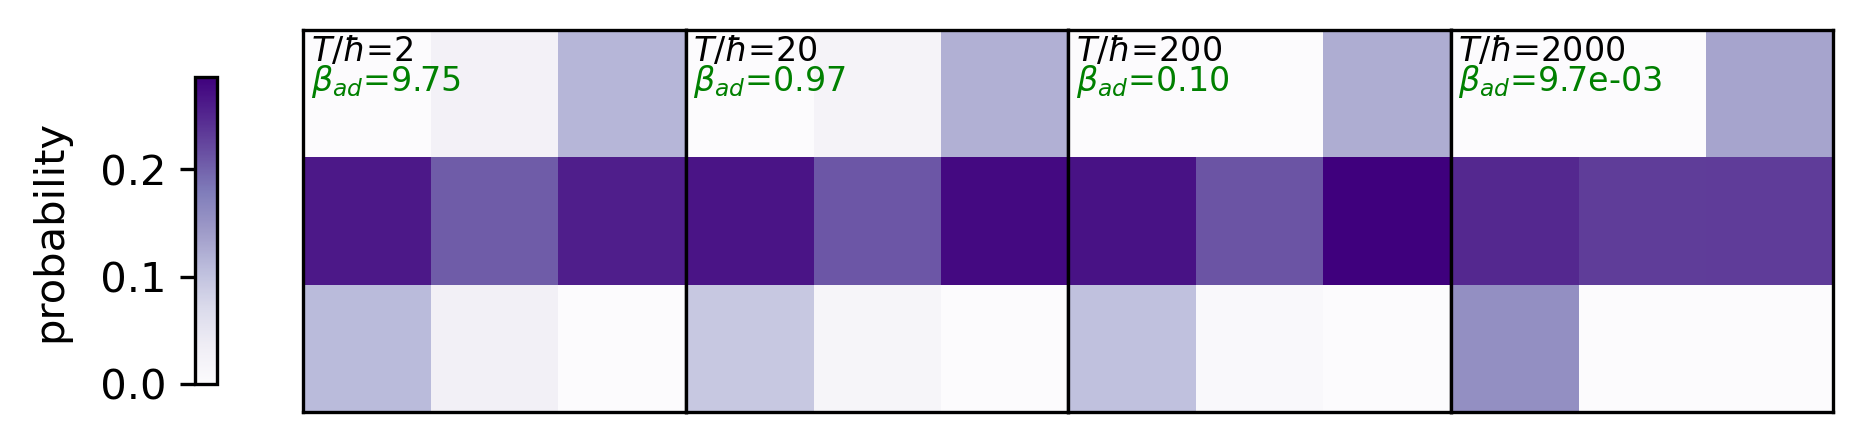

In [118]:
Tarr_fig_probs(pstuff_big_b,beta_b,Tarr_b,'','')
Tarr_fig_probs(pstuff_big_c,beta_c,Tarr_c,'','')